# Hugging Face Transformers Tutorial 

This notebook will give an introduction to the Hugging Face Transformers Python library and some common patterns that you can use to take advantage of it. It is most useful for using or fine-tuning pretrained transformer models for your projects.

Hugging Face provides access to models (both the code that implements them and their pre-trained weights, including latest LLMs like Llama3, DBRX, etc), model-specific tokenizers, as well as pipelines for common NLP tasks, and datasets and metrics in a separate datasets package. It has implementations in PyTorch, Tensorflow, and Flax (though we'll be using the PyTorch versions here!)

We're going to go through a few use cases:

- Overview of Tokenizers and Models

- Finetuning - for your own task. We'll use a sentiment-classification example.

## Resources

Here are additional resources introducing the library that were used to make this tutorial:

- [Hugging Face Documentation](https://www.google.com/url?q=https%3A%2F%2Fhuggingface.co%2Fdocs%2Ftransformers%2Findex)
    - Clear documentation
    - Tutorials, walk-throughs, and example notebooks
    - List of available models

- [Hugging Face Courses](https://huggingface.co/learn)

- [Hugging Face Examples](https://github.com/huggingface/transformers/tree/main/examples/pytorch).
    - You can find very similar code structures accross very different downstream tasks/models using Huggingface.

- [Hugging Face O'Reilly Book](https://www.oreilly.com/library/view/natural-language-processing/9781098136789/)

## Installations

For this notebook we will use following libraries. Please install it in your virtual environment before proceeding.

- transformers (`pip install transformers`)
- datasets (`pip install datasets`)
- accelerate (`pip install accelerate`)

## Importing necessaary libraries

In [1]:
from collections import defaultdict, Counter
import json

from matplotlib import pyplot as plt
import numpy as np
import torch

## Part 1: Common Pattern for using Hugging Face Transformers

We're going to start off with a common usage pattern for Hugging Face Transformers, using the example of Sentiment Analysis.

First, find a model on [the hub](https://huggingface.co/models). Anyone can upload their model for other people to use. (I'm using a sentiment analysis model from this [paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3489963)).

Then, there are two objects that need to be initialized - a **tokenizer**, and a **model**

- Tokenizer converts strings to lists of vocabulary ids that the model requires
- Model takes the vocabulary ids and produces a prediction

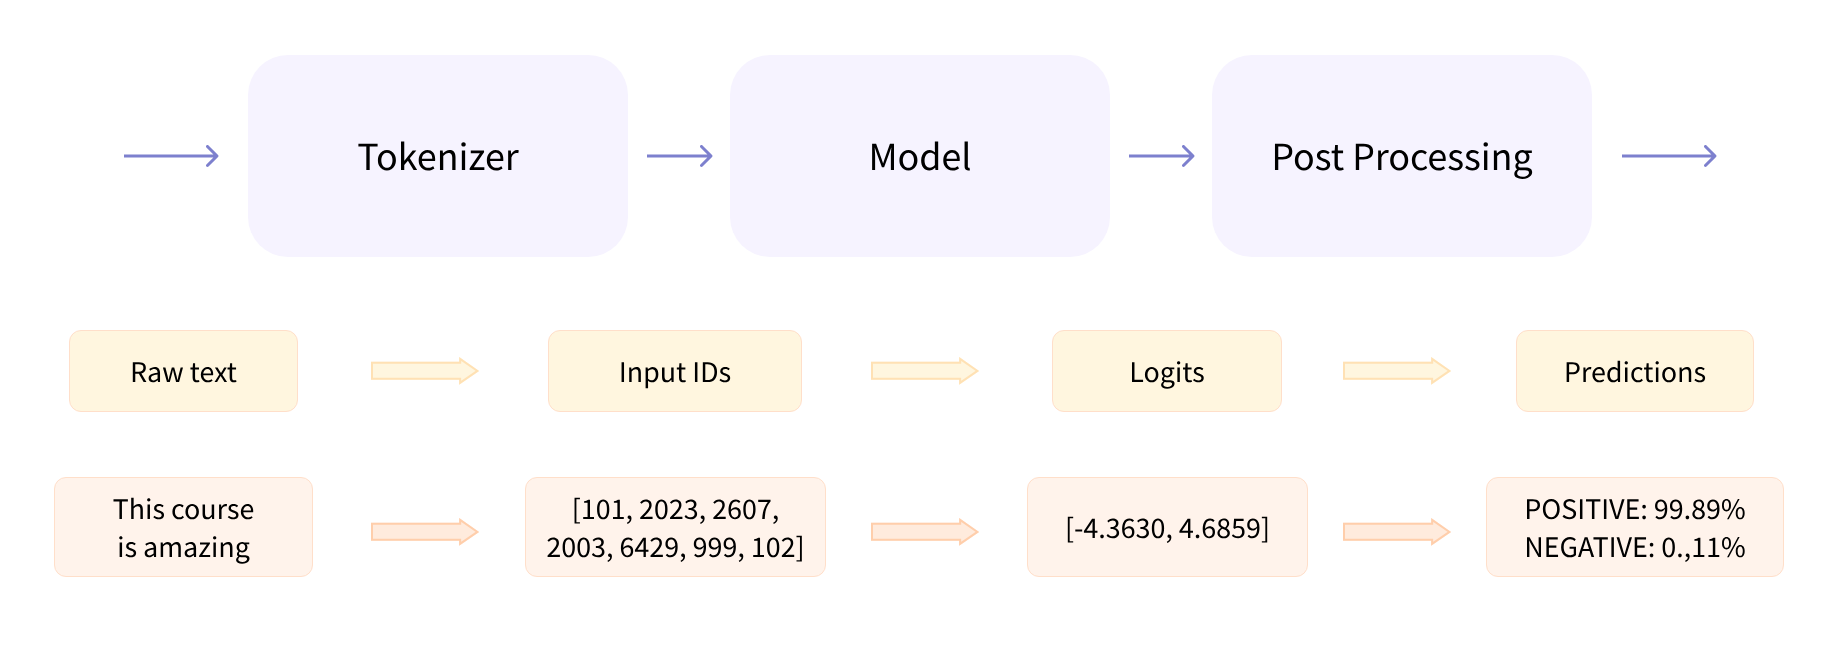

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")

# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english")

In [3]:
def print_encoding(model_inputs, indent=4):
    """Pretty print the model inputs dictionary."""
    indent_str = " " * indent
    print("{")
    for k, v in model_inputs.items():
        print(indent_str + k + ":")
        print(indent_str + indent_str + str(v))
    print("}")

In [4]:
inputs = "I'm excited to learn about Hugging Face Transformers!"
tokenized_inputs = tokenizer(inputs, return_tensors="pt")
outputs = model(**tokenized_inputs)

labels = ['NEGATIVE', 'POSITIVE']
prediction = torch.argmax(outputs.logits)


print("Input:")
print(inputs)
print()
print("Tokenized Inputs:")
print_encoding(tokenized_inputs)
print()
print("Model Outputs:")
print(outputs)
print()
print(f"The prediction is {labels[prediction]}")

Input:
I'm excited to learn about Hugging Face Transformers!

Tokenized Inputs:
{
    input_ids:
        tensor([[    0,   100,   437,  2283,     7,  1532,    59, 30581,  3923, 12346,
         34379,   328,     2]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
}

Model Outputs:
SequenceClassifierOutput(loss=None, logits=tensor([[-3.7605,  2.9262]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

The prediction is POSITIVE


### 1.1 Tokenizers

Pretrained models are implemented along with **tokenizers** that are used to preprocess their inputs. The tokenizers take raw strings or list of strings and output what are effectively dictionaries that contain the the model inputs.

You can access tokenizers either with the Tokenizer class specific to the model you want to use (say DistilBERT), or with the `AutoTokenizer` class. Fast Tokenizers are written in Rust, while their slow versions are written in Python.

In [5]:
from transformers import DistilBertTokenizer, DistilBertTokenizerFast, AutoTokenizer
name = "distilbert/distilbert-base-cased"
# name = "user/name" when loading from
# name = local_path when using save_pretrained() method

tokenizer = DistilBertTokenizer.from_pretrained(name)      # written in Python
print(tokenizer)

tokenizer = DistilBertTokenizerFast.from_pretrained(name)  # written in Rust
print(tokenizer)

tokenizer = AutoTokenizer.from_pretrained(name) # convenient! Defaults to Fast
print(tokenizer)

DistilBertTokenizer(name_or_path='distilbert/distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)
DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-cased', vocab_size=28996, model_max_length=5

In [6]:
# This is how you call the tokenizer
input_str = "Hugging Face Transformers is great!"
tokenized_inputs = tokenizer(input_str)


print("Vanilla Tokenization")
print_encoding(tokenized_inputs)
print()

# Two ways to access:
print(tokenized_inputs.input_ids)
print(tokenized_inputs["input_ids"])

Vanilla Tokenization
{
    input_ids:
        [101, 20164, 10932, 10289, 25267, 1110, 1632, 106, 102]
    attention_mask:
        [1, 1, 1, 1, 1, 1, 1, 1, 1]
}

[101, 20164, 10932, 10289, 25267, 1110, 1632, 106, 102]
[101, 20164, 10932, 10289, 25267, 1110, 1632, 106, 102]


In Hugging Face tokenizers, the attention_mask tells the model which tokens should be attended to (i.e., which are real tokens vs. padding).

Here’s what it means:

- 1 → Real token (should be attended to)

- 0 → Padding token (should be ignored)

In [7]:
cls = [tokenizer.cls_token_id]
sep = [tokenizer.sep_token_id]

# Tokenization happens in a few steps:
input_tokens = tokenizer.tokenize(input_str)
input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
input_ids_special_tokens = cls + input_ids + sep

# Decoding the ids back to full strings
decoded_str = tokenizer.decode(input_ids_special_tokens)

print("start:                ", input_str)
print("tokenize:             ", input_tokens)
print("convert_tokens_to_ids:", input_ids)
print("add special tokens:   ", input_ids_special_tokens)
print("--------")
print("decode:               ", decoded_str)

start:                 Hugging Face Transformers is great!
tokenize:              ['Hu', '##gging', 'Face', 'Transformers', 'is', 'great', '!']
convert_tokens_to_ids: [20164, 10932, 10289, 25267, 1110, 1632, 106]
add special tokens:    [101, 20164, 10932, 10289, 25267, 1110, 1632, 106, 102]
--------
decode:                [CLS] Hugging Face Transformers is great! [SEP]


The ## prefix in tokens like ##gging comes from WordPiece tokenization (used by BERT and related models).

It means:

> This token is a continuation of a word, not the start of a new one.

WordPiece splits rare or unknown words into smaller subword units so the model can handle vocabulary more flexibly.
For example:

> "unbelievable" → [ "un", "##bel", "##iev", "##able" ]

This lets the model understand prefixes, suffixes, and roots even if it hasn’t seen the full word before.

In [8]:
# The tokenizer can return pytorch tensors (useful for model inputs)

model_inputs = tokenizer("Hugging Face Transformers is great!", return_tensors="pt")
print("PyTorch Tensors:")
print_encoding(model_inputs)

PyTorch Tensors:
{
    input_ids:
        tensor([[  101, 20164, 10932, 10289, 25267,  1110,  1632,   106,   102]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])
}


In [9]:
# You can pass multiple strings into the tokenizer and pad them as you need

model_inputs = tokenizer(["Hugging Face Transformers is great!",
                         "The quick brown fox jumps over the lazy dog.",
                         "Then the dog got up and ran away because she didn't like foxes.",
                         ],
                         return_tensors="pt",
                         padding=True,
                         truncation=True)
print(f"Pad token: {tokenizer.pad_token} | Pad token id: {tokenizer.pad_token_id}")
print("Padding:")
print_encoding(model_inputs)

Pad token: [PAD] | Pad token id: 0
Padding:
{
    input_ids:
        tensor([[  101, 20164, 10932, 10289, 25267,  1110,  1632,   106,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  1109,  3613,  3058, 17594, 15457,  1166,  1103, 16688,  3676,
           119,   102,     0,     0,     0,     0,     0,     0,     0],
        [  101,  1599,  1103,  3676,  1400,  1146,  1105,  1868,  1283,  1272,
          1131,  1238,   112,   189,  1176, 17594,  1279,   119,   102]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
}


In [10]:
# You can also decode a whole batch at once:
print("Batch Decode:")
print(tokenizer.batch_decode(model_inputs.input_ids))
print()
print("Batch Decode: (no special characters)")
print(tokenizer.batch_decode(model_inputs.input_ids, skip_special_tokens=True))

Batch Decode:
['[CLS] Hugging Face Transformers is great! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', '[CLS] The quick brown fox jumps over the lazy dog. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', "[CLS] Then the dog got up and ran away because she didn ' t like foxes. [SEP]"]

Batch Decode: (no special characters)
['Hugging Face Transformers is great!', 'The quick brown fox jumps over the lazy dog.', "Then the dog got up and ran away because she didn ' t like foxes."]


### 1.2 Models

Initializing models is very similar to initializing tokenizers. You can either use the model class specific to your model or you can use an AutoModel class. I tend to prefer AutoModel, especially when I want to compare models, because it's easy to specify the models as strings.

While most of the pretrained transformers have similar architecture, there are additional weights, called "heads" that you have to train if you're doing sequence classification, question answering, or some other task. This is called fine-tuning. [This is similar to fine tuning pre-trained CNN model].

Hugging Face automatically sets up the architecture you need when you specify the model class. For example, 
- we are doing sentiment analysis, so we are going to use `DistilBertForSequenceClassification`. 
- If we were going to continue training DistilBERT on its masked-language modeling training objective, we would use `DistilBertForMaskedLM`, and 
- if we just wanted the model's representations, maybe for our own downstream task, we could just use `DistilBertModel`.

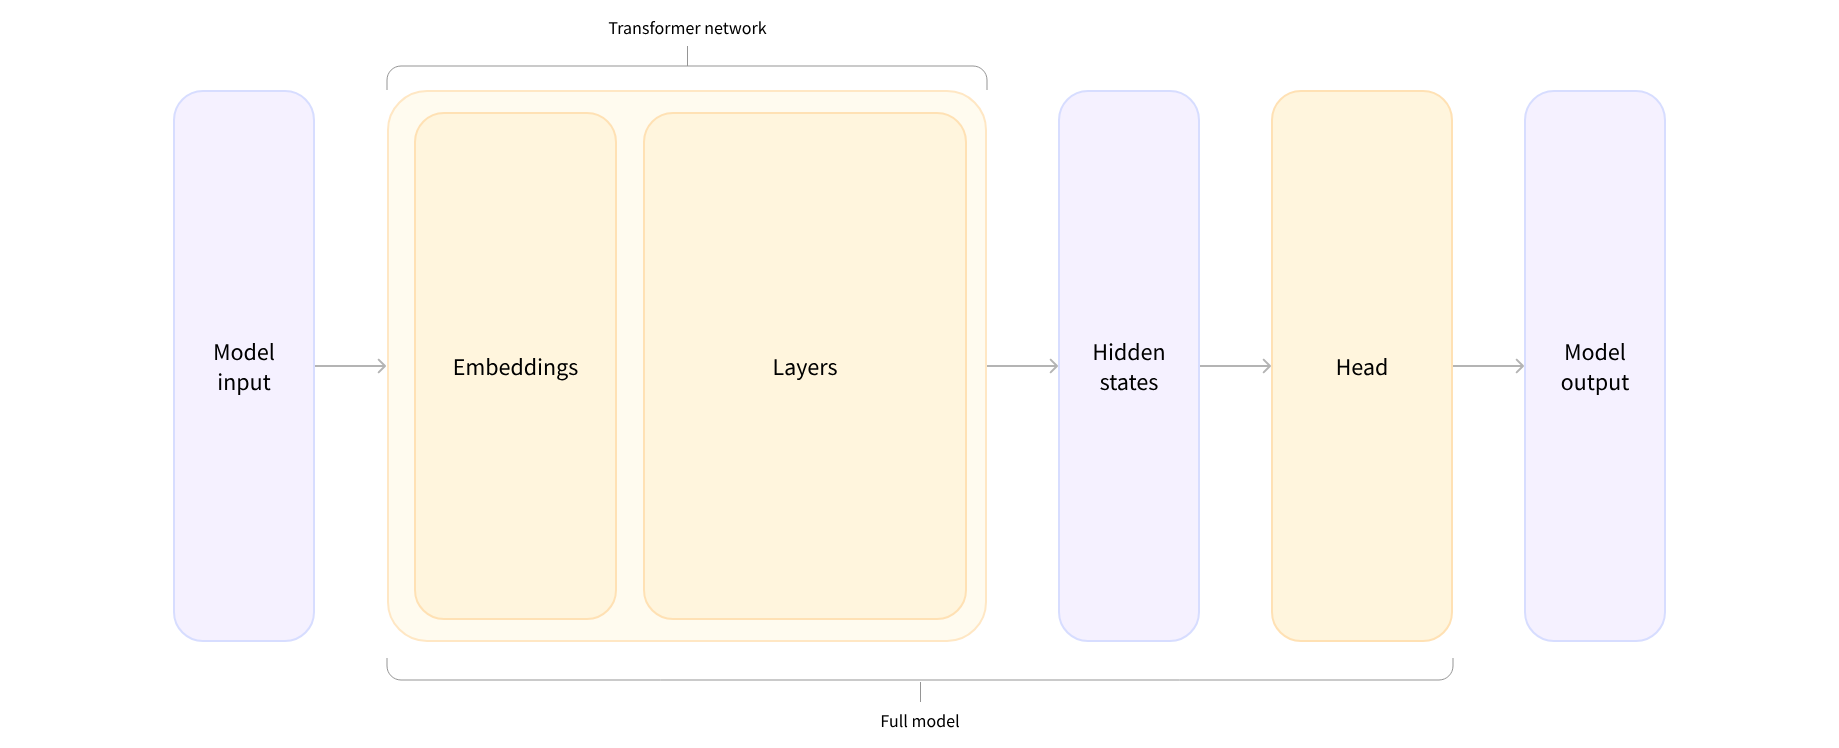

Here are some examples.
```
*Model
*ForMaskedLM
*ForSequenceClassification
*ForTokenClassification
*ForQuestionAnswering
*ForMultipleChoice
...
```
where * can be AutoModel or a specific pretrained model (e.g. DistilBert)

There are three types of models:

- **Encoders** (e.g. BERT)  [Suitable for classification, embedding]
- **Decoders** (e.g. GPT2)  [Suitable for generation]
- **Encoder-Decoder models** (e.g. BART or T5) [Suitable for Seq2Seq tasks, like machine transaltion]

The task-specific classes you have available depend on what type of model you're dealing with.

A full list of choices are available in the [docs](https://huggingface.co/docs/transformers/model_doc/auto). Note that not all models are compatible with all model architectures, for example DistilBERT is not compatible with the Seq2Seq models because it only consists of an encoder.

In [11]:
from transformers import AutoModelForSequenceClassification, DistilBertForSequenceClassification, DistilBertModel

print('Loading base model')
base_model = DistilBertModel.from_pretrained('distilbert-base-cased')

print("Loading classification model from base model's checkpoint")
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)

model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)

Loading base model
Loading classification model from base model's checkpoint


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


Passing inputs to the model is super easy. They take inputs as keyword arguments

In [13]:
input_str

'Hugging Face Transformers is great!'

In [14]:
model_inputs = tokenizer(input_str, return_tensors="pt")

# model_outputs = model(**model_inputs)  # another way to call
model_outputs = model(input_ids=model_inputs.input_ids, attention_mask=model_inputs.attention_mask)

print(model_inputs)
print()
print(model_outputs)
print()
print(f"Distribution over labels: {torch.softmax(model_outputs.logits, dim=1)}")

{'input_ids': tensor([[  101, 20164, 10932, 10289, 25267,  1110,  1632,   106,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}

SequenceClassifierOutput(loss=None, logits=tensor([[0.0187, 0.0169]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Distribution over labels: tensor([[0.5005, 0.4995]], grad_fn=<SoftmaxBackward0>)


These models are just Pytorch Modules! You can can calculate the loss with your loss_func and call `loss.backward`. You can use any of the optimizers or learning rate schedulers that you used.

In [15]:
# You can calculate the loss like normal
label = torch.tensor([1])
print(f"Label: {label}")
loss = torch.nn.functional.cross_entropy(model_outputs.logits, label)
print(loss)
loss.backward()

# You can get the parameters
list(model.named_parameters())[0]

Label: tensor([1])
tensor(0.6941, grad_fn=<NllLossBackward0>)


('distilbert.embeddings.word_embeddings.weight',
 Parameter containing:
 tensor([[-2.5130e-02, -3.3044e-02, -2.4396e-03,  ..., -1.0848e-02,
          -4.6824e-02, -9.4855e-03],
         [-4.8244e-03, -2.1486e-02, -8.7145e-03,  ..., -2.6029e-02,
          -3.7862e-02, -2.4103e-02],
         [-1.6531e-02, -1.7862e-02,  1.0596e-03,  ..., -1.6371e-02,
          -3.5670e-02, -3.1419e-02],
         ...,
         [-9.6466e-03,  1.4814e-02, -2.9182e-02,  ..., -3.7873e-02,
          -4.6263e-02, -1.6803e-02],
         [-1.3170e-02,  6.5378e-05, -3.7222e-02,  ..., -4.3558e-02,
          -1.1252e-02, -2.2152e-02],
         [ 1.1905e-02, -2.3293e-02, -2.2506e-02,  ..., -2.7136e-02,
          -4.3556e-02,  1.0529e-04]], requires_grad=True))

In [16]:
list(model.named_parameters())

[('distilbert.embeddings.word_embeddings.weight',
  Parameter containing:
  tensor([[-2.5130e-02, -3.3044e-02, -2.4396e-03,  ..., -1.0848e-02,
           -4.6824e-02, -9.4855e-03],
          [-4.8244e-03, -2.1486e-02, -8.7145e-03,  ..., -2.6029e-02,
           -3.7862e-02, -2.4103e-02],
          [-1.6531e-02, -1.7862e-02,  1.0596e-03,  ..., -1.6371e-02,
           -3.5670e-02, -3.1419e-02],
          ...,
          [-9.6466e-03,  1.4814e-02, -2.9182e-02,  ..., -3.7873e-02,
           -4.6263e-02, -1.6803e-02],
          [-1.3170e-02,  6.5378e-05, -3.7222e-02,  ..., -4.3558e-02,
           -1.1252e-02, -2.2152e-02],
          [ 1.1905e-02, -2.3293e-02, -2.2506e-02,  ..., -2.7136e-02,
           -4.3556e-02,  1.0529e-04]], requires_grad=True)),
 ('distilbert.embeddings.position_embeddings.weight',
  Parameter containing:
  tensor([[ 0.0234,  0.0052, -0.0135,  ...,  0.0015,  0.0140,  0.0098],
          [-0.0269, -0.0048, -0.0055,  ...,  0.0059,  0.0046, -0.0055],
          [-0.0139, -0.0

**Question-1: Why all the layers have `requires_grad = True`?**

Hugging Face loads the pretrained weights for the base DistilBERT and adds a new classification head (a linear layer).

The default behavior in Hugging Face is to fine-tune the entire model (i.e., update both the base transformer and the classification head).

The library does not automatically freeze the base model — it leaves it up to you.

To freeze the weight of DistilBERT parameter and finetune only the classification head:

```python
for param in model.distilbert.parameters():
    param.requires_grad = False
```

This way, only the classification head’s weights (e.g., model.classifier) will update during training.


**Question-2: why `distilbert.embeddings.position_embeddings.weight` has `requires_grad = True`? Isn't the Postional embedding not trainable?**

In BERT and its variants like DistilBERT, RoBERTa and GPT as well has trainable position embeddings. The original transformer by Vaswani et. al. had sinusoidal non-trainable postition embedding. However, BERT and its variants have learned absolute position embeddings.

Hugging Face provides an additional easy way to calculate the loss as well:

In [17]:
# To calculate the loss, we need to pass in a label:
model_inputs = tokenizer(input_str, return_tensors="pt")

labels = ['NEGATIVE', 'POSITIVE']
model_inputs['labels'] = torch.tensor([1])
print(model_inputs)

model_outputs = model(**model_inputs)

print(model_outputs)
print()
print(f"Model predictions: {labels[model_outputs.logits.argmax()]}")

{'input_ids': tensor([[  101, 20164, 10932, 10289, 25267,  1110,  1632,   106,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'labels': tensor([1])}
SequenceClassifierOutput(loss=tensor(0.6941, grad_fn=<NllLossBackward0>), logits=tensor([[0.0187, 0.0169]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Model predictions: NEGATIVE


One final note - you can get the hidden states and attention weights from the models really easily. This is particularly helpful if you're working on an analysis project. (For example, see [What does BERT look at?](https://arxiv.org/abs/1906.04341)).

In [18]:
from transformers import AutoModel

model = AutoModel.from_pretrained("distilbert-base-cased", output_attentions=True, output_hidden_states=True)
model.eval()

model_inputs = tokenizer(input_str, return_tensors="pt")
with torch.no_grad():
    model_output = model(**model_inputs)


print("Hidden state size (per layer):  ", model_output.hidden_states[0].shape)
print("Attention head size (per layer):", model_output.attentions[0].shape)     # (layer, batch, query_word_idx, key_word_idxs)
                                                                               # y-axis is query, x-axis is key
# print(model_output)

Hidden state size (per layer):   torch.Size([1, 9, 768])
Attention head size (per layer): torch.Size([1, 12, 9, 9])


['[CLS]', 'Hu', '##gging', 'Face', 'Transformers', 'is', 'great', '!', '[SEP]']


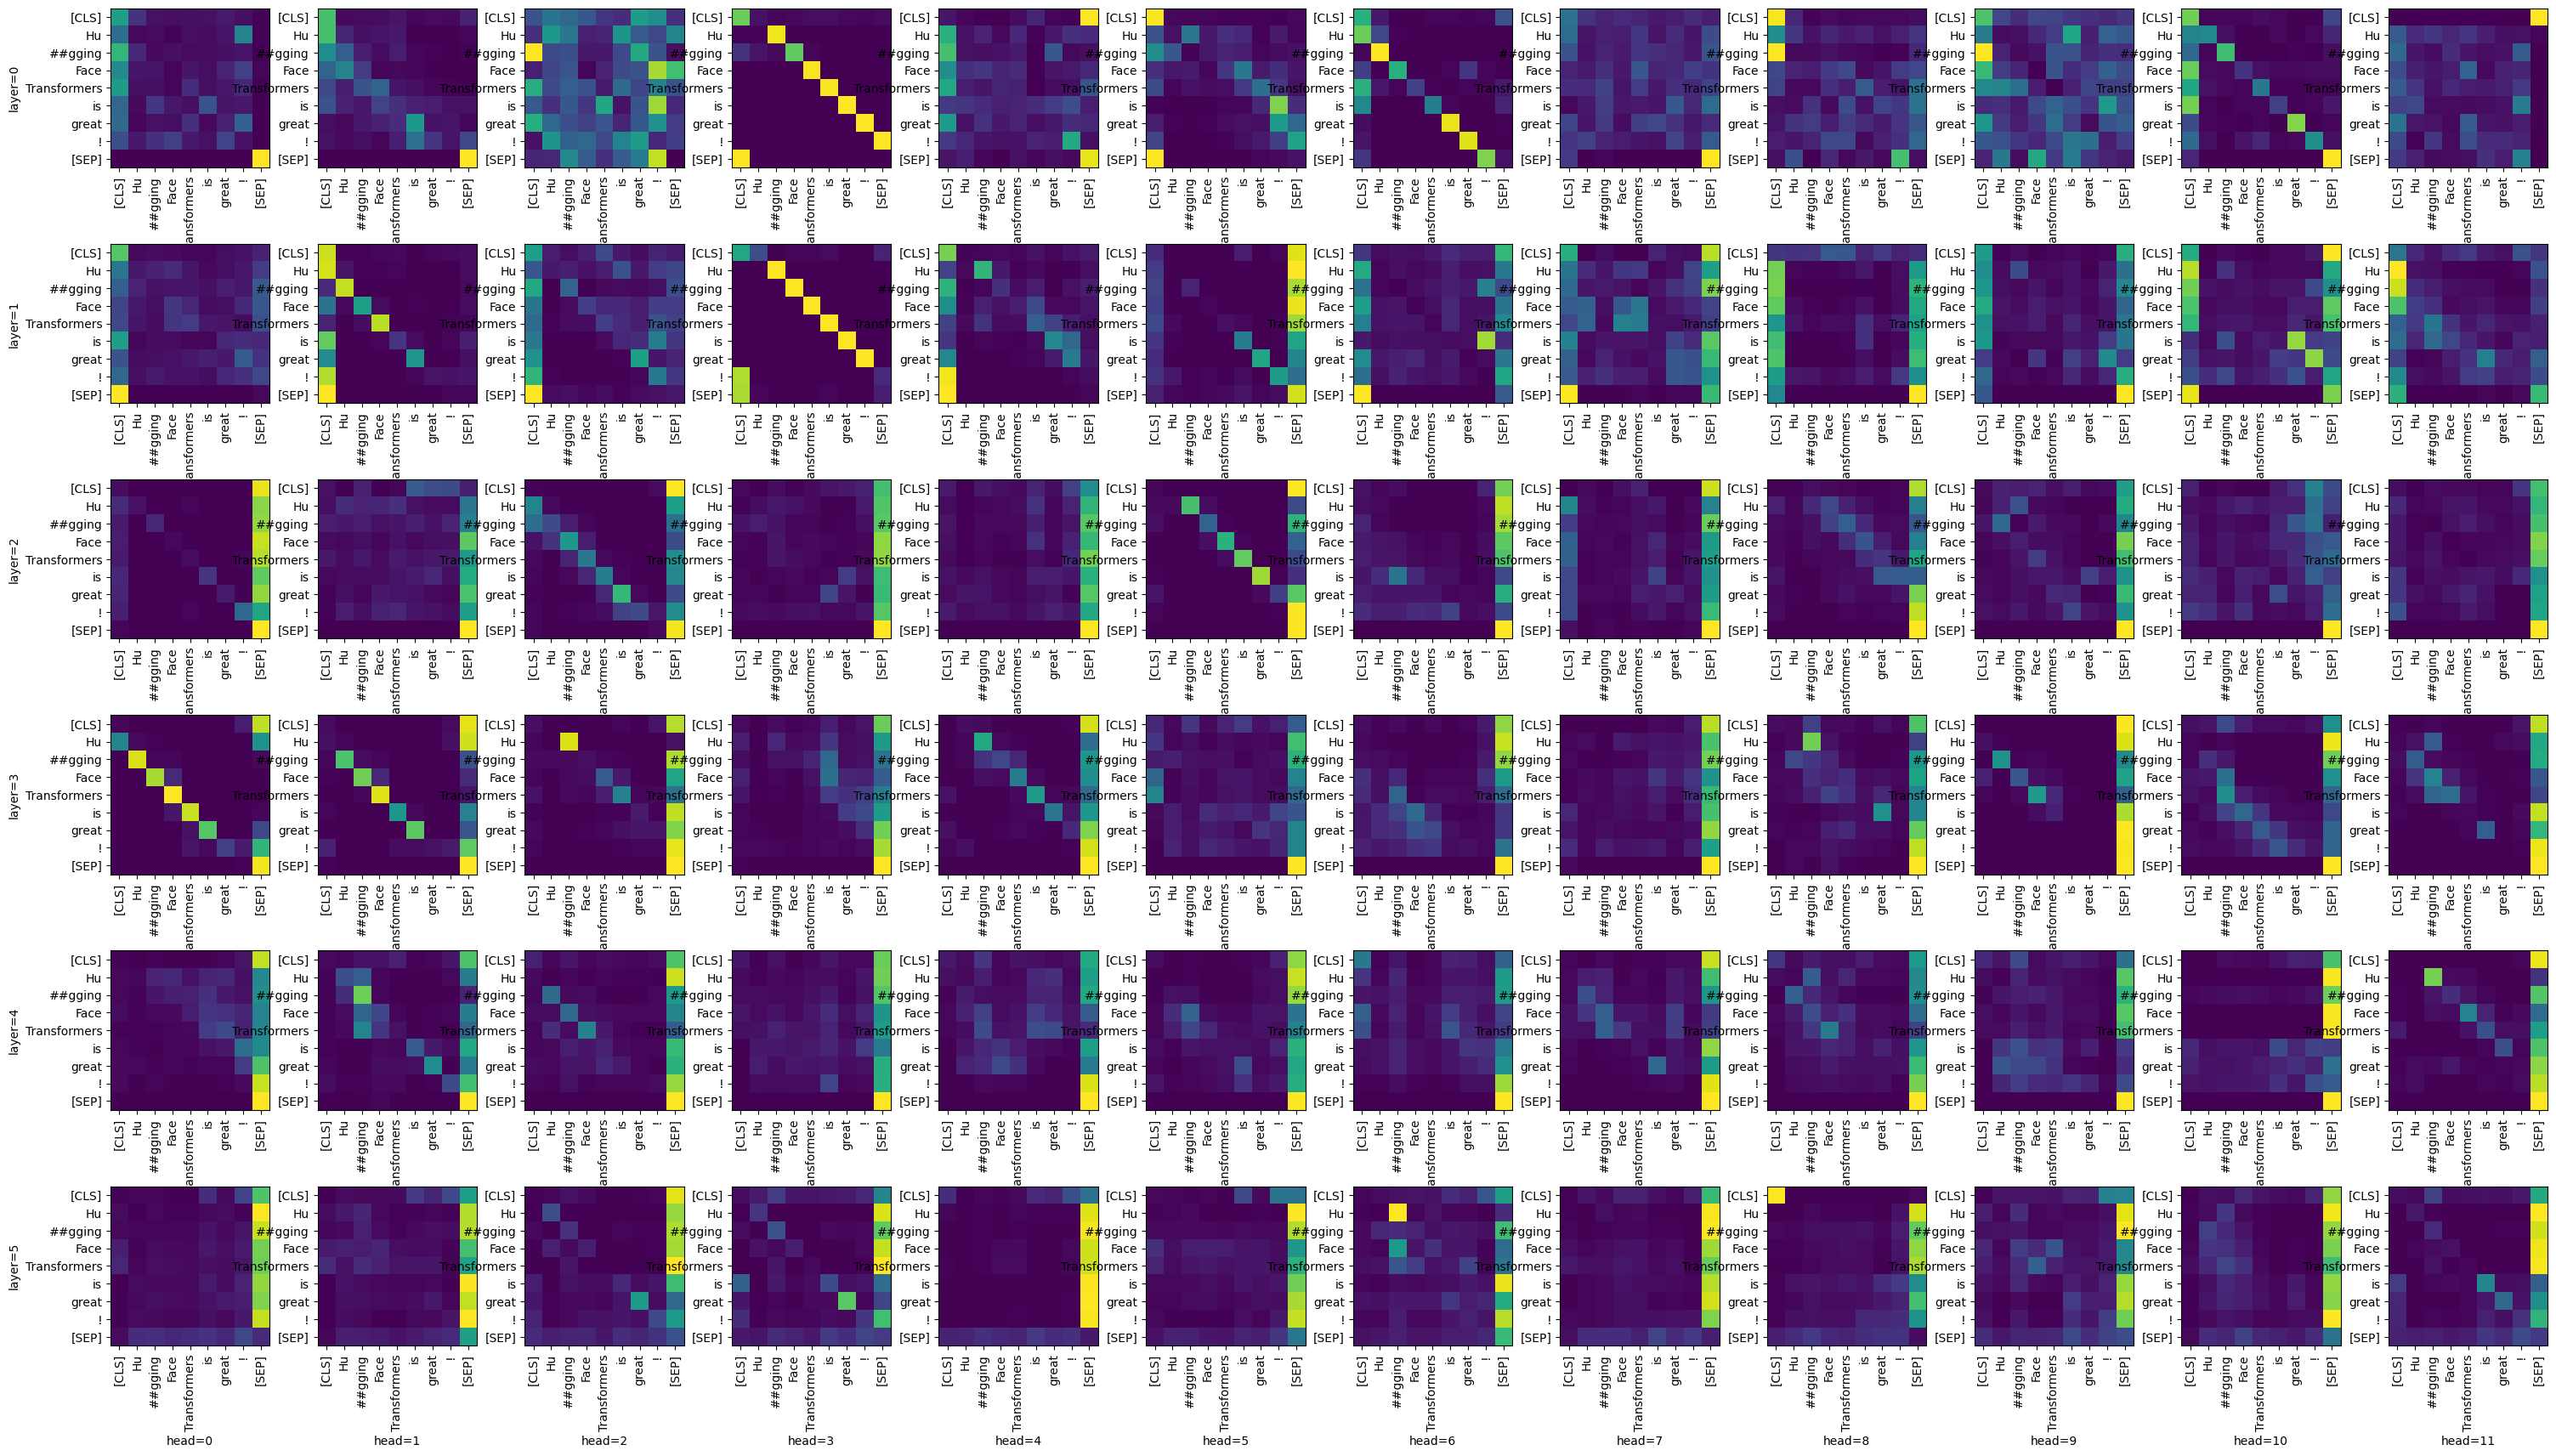

In [19]:
tokens = tokenizer.convert_ids_to_tokens(model_inputs.input_ids[0])
print(tokens)


n_layers = len(model_output.attentions)
n_heads = len(model_output.attentions[0][0])
fig, axes = plt.subplots(6, 12)
fig.set_size_inches(18.5*2, 10.5*2)
for layer in range(n_layers):
    for i in range(n_heads):
        axes[layer, i].imshow(model_output.attentions[layer][0, i])
        axes[layer][i].set_xticks(list(range(9)))
        axes[layer][i].set_xticklabels(labels=tokens, rotation="vertical")
        axes[layer][i].set_yticks(list(range(9)))
        axes[layer][i].set_yticklabels(labels=tokens)

        if layer == 5:
            axes[layer, i].set(xlabel=f"head={i}")
        if i == 0:
            axes[layer, i].set(ylabel=f"layer={layer}")

plt.subplots_adjust(wspace=0.3)
plt.show()

## Part-2: Finetuning

We will fine-tune **DistilBERT model** on imdb moview review dataset to classify the sentiment of the reviews.

### 2.1 Loading the dataset

In addition to having models, the [the hub](https://huggingface.co/datasets) also has datasets.

In [20]:
from datasets import load_dataset, DatasetDict

# DataLoader(zip(list1, list2))
dataset_name = "stanfordnlp/imdb"

imdb_dataset = load_dataset(dataset_name)


# Just take the first 50 tokens for speed (in general, you wouldn't do this)
def truncate(example):
    return {
        'text': " ".join(example['text'].split()[:50]),
        'label': example['label']
    }

imdb_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [21]:
# Take 128 random examples for train and 32 validation (for speed, in general you wouldn't do this)

small_imdb_dataset = DatasetDict(
    train=imdb_dataset['train'].shuffle(seed=1111).select(range(128)).map(truncate),
    val=imdb_dataset['train'].shuffle(seed=1111).select(range(128, 160)).map(truncate),
)
small_imdb_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 128
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 32
    })
})

In [22]:
small_imdb_dataset['train'][:10]

{'text': ["Probably Jackie Chan's best film in the 1980s, and the one that put him on the map. The scale of this self-directed police drama is evident from the opening and closing scenes, during which a squatters' village and shopping mall are demolished. There are, clearly, differences between the original Chinese",
  'A wonderful movie! Anyone growing up in an Italian family will definitely see themselves in these characters. A good family movie with sadness, humor, and very good acting from all. You will enjoy this movie!! We need more like it.',
  'HORRENDOUS! Avoid like the plague. I would rate this in the top 10 worst movies ever. Special effects, acting, mood, sound, etc. appear to be done by day care students...wait, I have seen programs better than this. Opens like a soft porn show with a blurred nude female doing a',
  'And I absolutely adore Isabelle Blais!!! She was so cute in this movie, and far different from her role in "Quebec-Montreal" where she was more like a man-eat

In [23]:
# Prepare the dataset - this tokenizes the dataset in batches of 16 examples.
# padding=True : Pads all sequences in the batch to the same maximum length in the batch
# truncation=True : Truncates sequences longer than the model's maximum acceptable input length (512 for BERT, 1024 for RoBERTa, etc.)

small_tokenized_dataset = small_imdb_dataset.map(
    lambda example: tokenizer(example['text'], padding=True, truncation=True), # https://huggingface.co/docs/transformers/pad_truncation
    batched=True,
    batch_size=16
)

# print(small_tokenized_dataset)
small_tokenized_dataset = small_tokenized_dataset.remove_columns(["text"])
small_tokenized_dataset = small_tokenized_dataset.rename_column("label", "labels")
small_tokenized_dataset.set_format("torch")

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

In [24]:
small_tokenized_dataset['train'][0:2]

{'labels': tensor([1, 1]),
 'input_ids': tensor([[  101, 10109,  9662, 10185,   112,   188,  1436,  1273,  1107,  1103,
           3011,   117,  1105,  1103,  1141,  1115,  1508,  1140,  1113,  1103,
           4520,   119,  1109,  3418,  1104,  1142,  2191,   118,  2002,  2021,
           3362,  1110, 10238,  1121,  1103,  2280,  1105,  5134,  4429,   117,
           1219,  1134,   170,  4816,  6718, 18899,   112,  1491,  1105,  6001,
           8796,  1132,  6515,   119,  1247,  1132,   117,  3817,   117,  5408,
           1206,  1103,  1560,  1922,   102,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0],
         [  101,   138,  7310,  2523,   106, 15859,  2898,  1146,  1107,  1126,
           2169,  1266,  1209,  5397,  1267,  2310,  1107,  1292,  2650,   119,
            138,  1363,  1266,  2523,  1114, 12928,   1

In [25]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(small_tokenized_dataset['train'], batch_size=16)
eval_dataloader = DataLoader(small_tokenized_dataset['val'], batch_size=16)

### 2.2 Training

To train your models, you can just use the same kind of training loop that you would use in Pytorch. Hugging Face models are also torch.nn.Modules so backpropagation happens the same way and you can even use the same optimizers. Hugging Face also includes optimizers and learning rate schedules that were used to train Transformer models, so you can use these too.

For optimization, we're using the **AdamW Optimizer**, which is almost identical to Adam except it also includes weight decay. And we're using a linear learning rate scheduler, which reduces the learning rate a little bit after each training step over the course of training.

In [26]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm.notebook import tqdm


model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)

num_epochs = 3
num_training_steps = len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

best_val_loss = float("inf")
progress_bar = tqdm(range(num_training_steps))
for epoch in range(num_epochs):
    # training
    model.train()
    for batch_i, batch in enumerate(train_dataloader):

        # batch = ([text1, text2], [0, 1])

        output = model(**batch)

        optimizer.zero_grad()
        output.loss.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)

    # validation
    model.eval()
    loss = 0.0
    for batch_i, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            output = model(**batch)
        loss += output.loss

    avg_val_loss = loss / len(eval_dataloader)
    print(f"Validation loss: {avg_val_loss}")
    if avg_val_loss < best_val_loss:
        print("Saving checkpoint!")
        best_val_loss = avg_val_loss
        # torch.save({
        #     'epoch': epoch,
        #     'model_state_dict': model.state_dict(),
        #     'optimizer_state_dict': optimizer.state_dict(),
        #     'val_loss': best_val_loss,
        #     },
        #     f"checkpoints/epoch_{epoch}.pt"
        # )

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/8 [00:00<?, ?it/s]

Validation loss: 0.6965458393096924
Saving checkpoint!
Validation loss: 0.6965458393096924
Validation loss: 0.6965458393096924


While you can use PyTorch to train your models, Hugging Face offers a powerful **Trainer** class to handle most needs. I think it works pretty well, though there are some customizations I'd recommend.

`TrainingArguments` specifies different training parameters like how often to evaluate and save model checkpoints, where to save them, etc. There are **many** aspects you can customize and it's worth checking them out here. Some things you can control include:

- learning rate, weight decay, gradient clipping,
- checkpointing, logging, and evaluation frequency
- where you log to (default is tensorboard, but if you use WandB or MLFlow they have integrations)

The Trainer actually performs the training. You can pass it the TrainingArguments, model, the datasets, tokenizer, optimizer, and even model checkpoints to resume training from. The compute_metrics function is called at the end of evaluation/validation to calculate evaluation metrics.

In [27]:
from transformers import TrainingArguments, Trainer

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)

arguments = TrainingArguments(
    output_dir="sample_hf_trainer",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    eval_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    learning_rate=2e-5,
    load_best_model_at_end=True,
    seed=224
)


def compute_metrics(eval_pred):
    """Called at the end of validation. Gives accuracy"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # calculates the accuracy
    return {"accuracy": np.mean(predictions == labels)}


trainer = Trainer(
    model=model,
    args=arguments,
    train_dataset=small_tokenized_dataset['train'],
    eval_dataset=small_tokenized_dataset['val'], # change to test when you do your final evaluation!
    processing_class=tokenizer,                  # tokenizer to use for processing
    compute_metrics=compute_metrics
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Callbacks: Logging and Early Stopping


Hugging Face Transformers also allows you to write `Callbacks` if you want certain things to happen at different points during training (e.g. after evaluation or after an epoch has finished). For example, there is a callback for early stopping, and I usually write one for logging as well.

For more information on callbacks see [here](https://huggingface.co/docs/transformers/main_classes/callback#transformers.TrainerCallback).

In [28]:
from transformers import TrainerCallback, EarlyStoppingCallback

class LoggingCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path
    # will call on_log on each logging step, specified by TrainerArguement. (i.e TrainerArguement.logginng_step)
    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero:
            with open(self.log_path, "a") as f:
                f.write(json.dumps(logs) + "\n")
    # def on_epoch(...)

trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=1, early_stopping_threshold=0.0))
trainer.add_callback(LoggingCallback("sample_hf_trainer/log.jsonl"))

In [29]:
# train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.686681,0.656250
2,No log,0.685183,0.656250


TrainOutput(global_step=16, training_loss=0.6907578706741333, metrics={'train_runtime': 5.1423, 'train_samples_per_second': 49.783, 'train_steps_per_second': 3.111, 'train_loss': 0.6907578706741333, 'epoch': 2.0})

In [30]:
# evaluating the model is very easy

results = trainer.evaluate()                           # just gets evaluation metrics

print(results)

{'eval_loss': 0.6851828098297119, 'eval_accuracy': 0.65625, 'eval_runtime': 0.0567, 'eval_samples_per_second': 564.177, 'eval_steps_per_second': 35.261, 'epoch': 2.0}


In [31]:
predictions = trainer.predict(small_tokenized_dataset['val']) # also gives you predictions

predictions

PredictionOutput(predictions=array([[0.09165381, 0.07962041],
       [0.06380588, 0.11794902],
       [0.08488687, 0.08082821],
       [0.1049441 , 0.06731595],
       [0.06396932, 0.1075198 ],
       [0.12672846, 0.10062526],
       [0.11917815, 0.05151489],
       [0.08873225, 0.07813683],
       [0.10081768, 0.10288484],
       [0.09219088, 0.13225915],
       [0.06996837, 0.0754431 ],
       [0.1380498 , 0.04071938],
       [0.09543996, 0.0506416 ],
       [0.08256689, 0.11317845],
       [0.07321215, 0.04383454],
       [0.12334026, 0.03900501],
       [0.10490795, 0.05919657],
       [0.05522797, 0.07971678],
       [0.11438451, 0.07652677],
       [0.02722666, 0.09858356],
       [0.09510586, 0.04713748],
       [0.09813032, 0.07833774],
       [0.06824371, 0.09338139],
       [0.09816677, 0.08074994],
       [0.06191546, 0.10526577],
       [0.08007171, 0.10138091],
       [0.06911012, 0.06928797],
       [0.08618958, 0.08113609],
       [0.04956729, 0.11129271],
       [0.1032

In [32]:
# To load our saved model, we can pass the path to the checkpoint into the `from_pretrained` method:
test_str = "I liked the movie but it was too long!"

finetuned_model = AutoModelForSequenceClassification.from_pretrained("sample_hf_trainer/checkpoint-8")
model_inputs = tokenizer(test_str, return_tensors="pt")
prediction = torch.argmax(finetuned_model(**model_inputs).logits)
print(["NEGATIVE", "POSITIVE"][prediction])

POSITIVE


Some practical tips for fine-tuning:

**Good default hyperparameters**. The hyperparameters you will depend on your task and dataset. You should do a hyperparameter search to find the best ones. That said, here are some good initial values for fine-tuning.

- Epochs: {3, 4, 5} (larger amounts of data need fewer epochs)
- Batch size (bigger is better: as large as you can make it)
- Optimizer: AdamW
- AdamW learning rate: {2e-5, 5e-5}
- Learning rate scheduler: linear warm up for first {0, 100, 500} steps of training
- weight_decay (l2 regularization): {0, 0.01, 0.1}

You should monitor your validation loss to decide when you've found good hyperparameters.

## Part-3: Generation

In the example above we finetuned the model on a classification task, but you can also finetune models on generation tasks. The `generate` function makes it easy to generate from these models.

In [33]:
from transformers import AutoModelForCausalLM

gpt2_tokenizer = AutoTokenizer.from_pretrained('gpt2')

gpt2 = AutoModelForCausalLM.from_pretrained('distilgpt2')
gpt2.config.pad_token_id = gpt2.config.eos_token_id  # Prevents warning during decoding

In [34]:
prompt = "Once upon a time in a land far, far away, there lived a"

tokenized_prompt = gpt2_tokenizer(prompt, return_tensors="pt")

for i in range(10):
    output = gpt2.generate(**tokenized_prompt,
                  max_length=50,
                  do_sample=True,
                  top_p=0.9)

    print(f"{i + 1}) {gpt2_tokenizer.batch_decode(output)[0]}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1) Once upon a time in a land far, far away, there lived a living life, and a very different life. A human life lived there, and a person who lived there existed and who lived there existed and lived there.
The main difference


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2) Once upon a time in a land far, far away, there lived a living, just as if it were the life of a man; no man was born without his arms.

The most famous and popular story of the 18th century's


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


3) Once upon a time in a land far, far away, there lived a civilization that knew its people better than anything they had ever heard before: men, women, men, and men.



To be sure, this is the only


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


4) Once upon a time in a land far, far away, there lived a great body of people whose lives were still being kept within their control.

They lived long life, living a beautiful life, living on their own, and lived and lived


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


5) Once upon a time in a land far, far away, there lived a certain kind of child, and in them there lived a certain sort of human child. These children existed, at a certain moment, as the child's age, their ability to


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


6) Once upon a time in a land far, far away, there lived a single person. But that had nothing to do with the way they lived in their homes. There was no place for a man to live. A person would find themselves in a


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


7) Once upon a time in a land far, far away, there lived a vast collection of prehistoric creatures which had lived in the most primitive of land. And now, they are known as the Eucharist, who believe it is the most important event


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


8) Once upon a time in a land far, far away, there lived a multitude of men and women.


For centuries, the vast majority of people of East Africa are living in the same kind of conditions, and their lives are governed by


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


9) Once upon a time in a land far, far away, there lived a different race.
And yet the same people, in the same way they have in their homeland, feel the need to protect themselves against the rise of the most dangerous, most
10) Once upon a time in a land far, far away, there lived a group of individuals in the midst of a new civilization. They could have been the first to bring forth a civilization from above, with no purpose for them. It was the first


## Part-4: Pipelines

There are some standard NLP tasks like sentiment classification or question answering where there are already pre-trained (and fine-tuned!) models available through Hugging Face Transformer's [_Pipeline_](https://huggingface.co/docs/transformers/en/main_classes/pipelines) interface.

Here's an example with Sentiment Analysis:

In [35]:
from transformers import pipeline

sentiment_analysis = pipeline("sentiment-analysis", model="siebert/sentiment-roberta-large-english")

Device set to use cuda:0


You can run the pipeline by just calling it on a string.

In [36]:
sentiment_analysis("Hugging Face Transformers is really cool!")

[{'label': 'POSITIVE', 'score': 0.998448371887207}]

Or on a list of strings:

In [37]:
sentiment_analysis(["I didn't know if I would like Hákarl, but it turned out pretty good.",
                    "I didn't know if I would like Hákarl, and it was just as bad as I'd heard."])

[{'label': 'POSITIVE', 'score': 0.9988769888877869},
 {'label': 'NEGATIVE', 'score': 0.9994940757751465}]

In [38]:
# multi-class emotion classification

classifier = pipeline(
    "text-classification",
    model="bhadresh-savani/distilbert-base-uncased-emotion",  # multi-class model
    return_all_scores=True
)

text = "I’m feeling really happy and excited today!"
preds = classifier(text)
print(preds)

Device set to use cuda:0


[[{'label': 'sadness', 'score': 0.00022967279073782265}, {'label': 'joy', 'score': 0.9990209341049194}, {'label': 'love', 'score': 0.00029158839606679976}, {'label': 'anger', 'score': 0.0001228837645612657}, {'label': 'fear', 'score': 0.0001377563166897744}, {'label': 'surprise', 'score': 0.00019710468768607825}]]


c:\Users\Sourav Karmakar\Desktop\Work\LogicMojo\logicmojo-data-science-april-2025\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Here:

- Each label has a probability (softmax score).

- You can take the top-scoring label for prediction:

In [39]:
result = max(preds[0], key=lambda x: x['score'])
print(result['label'])

joy


Text summarization example

In [40]:
summarizer_pipeline = pipeline("summarization", model="facebook/bart-large-cnn")

summarizer_pipeline("The Hugging Face Transformers library provides a simple and efficient way to work with state-of-the-art natural language processing models. It offers a wide range of pre-trained models for various tasks such as text classification, named entity recognition, question answering, and text generation. The library is built on top of PyTorch and TensorFlow, making it easy to integrate into existing machine learning workflows. With its user-friendly API and extensive documentation, Hugging Face Transformers has become a popular choice among researchers and developers in the NLP community.",
                    max_length=30,
                    min_length=10,
                    do_sample=False)

Device set to use cuda:0


[{'summary_text': 'The Hugging Face Transformers library provides a simple and efficient way to work with state-of-the-art natural language processing models.'}]

## Part-5: Masked Language Modeling

In [41]:
from transformers import AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", fast=True)
bert = AutoModelForMaskedLM.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [42]:
prompt = "I am [MASK] to learn about HuggingFace!"
model = pipeline("fill-mask", "bert-base-cased")
model(prompt)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


[{'score': 0.3552902340888977,
  'token': 7215,
  'token_str': 'excited',
  'sequence': 'I am excited to learn about HuggingFace!'},
 {'score': 0.15621213614940643,
  'token': 1280,
  'token_str': 'going',
  'sequence': 'I am going to learn about HuggingFace!'},
 {'score': 0.0789346694946289,
  'token': 9582,
  'token_str': 'eager',
  'sequence': 'I am eager to learn about HuggingFace!'},
 {'score': 0.03559965267777443,
  'token': 1303,
  'token_str': 'here',
  'sequence': 'I am here to learn about HuggingFace!'},
 {'score': 0.035240888595581055,
  'token': 17261,
  'token_str': 'delighted',
  'sequence': 'I am delighted to learn about HuggingFace!'}]

In [43]:
inputs = tokenizer(prompt, return_tensors="pt")
mask_index = np.where(inputs['input_ids'] == tokenizer.mask_token_id)
outputs = bert(**inputs)
top_5_predictions = torch.softmax(outputs.logits[mask_index], dim=1).topk(5)

print(prompt)
for i in range(5):
    prediction = tokenizer.decode(top_5_predictions.indices[0, i])
    prob = top_5_predictions.values[0, i]
    print(f"  {i+1}) {prediction}\t{prob:.3f}")

I am [MASK] to learn about HuggingFace!
  1) excited	0.355
  2) going	0.156
  3) eager	0.079
  4) here	0.036
  5) delighted	0.035


## Appendix-1: Defining Custom Dataset

There are a few ways to go about defining datasets, but I'm going to show an example using Pytorch Dataloaders. This example uses a very small sample from an encoder-decoder dataaset,the [E2E Dataset](https://www.kaggle.com/datasets/sushii2512/e2e-dataset), which is maps structured information about restaurants to natural language descriptions.


In [44]:
import csv
from torch.utils.data import Dataset, DataLoader

In [45]:
class E2EDataset(Dataset):
    def __init__(self, filepath, tokenizer):
    
        with open(filepath, newline="") as f:
            reader = csv.reader(f)
            next(reader)  # skip header
            self.data = [{"source": row[0], "target": row[1]} for row in reader]
        
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        inputs = self.tokenizer(self.data[idx]['source'])
        labels = self.tokenizer(self.data[idx]['target'])
        # Add labels to inputs
        inputs['labels'] = labels["input_ids"]
        return inputs

In [46]:
bart_tokenizer = AutoTokenizer.from_pretrained('facebook/bart-base')

In [47]:
dataset = E2EDataset("./sample_e2e_dataset.csv", bart_tokenizer)

In [48]:
dataset[0]

{'input_ids': [0, 13650, 10975, 133, 48596, 7479, 3529, 40118, 10975, 22478, 7479, 425, 43430, 10975, 4321, 87, 1437, 13572, 17, 15113, 2537, 29254, 541, 7479, 2111, 691, 10975, 245, 66, 9, 195, 7479, 583, 10975, 347, 2001, 13572, 8188, 10659, 2537, 14800, 1614, 1069, 5183, 742, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [0, 133, 48596, 8881, 583, 34445, 13572, 8188, 10659, 2537, 14800, 1614, 1069, 5183, 34, 10, 195, 999, 691, 4, 1437, 14614, 386, 23, 1437, 13572, 17, 15113, 2537, 29254, 541, 4, 2]}

In [49]:
batch = bart_tokenizer(
    ["This is the first test.", "This is the second test."],
    text_target=["Target 1", "Target 2"],
    padding=True,
    truncation=True,
    return_tensors="pt"
)

print_encoding(batch)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{
    input_ids:
        tensor([[   0,  713,   16,    5,   78, 1296,    4,    2],
        [   0,  713,   16,    5,  200, 1296,    4,    2]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1]])
    labels:
        tensor([[    0, 41858,   112,     2],
        [    0, 41858,   132,     2]])
}
